# 0. Import packages

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

# 1. Summary
- FFN(x) = max(0, xW1 + b1)W2 + b2
- Same FFN parameters shared across all positions (so it’s efficient)
- In BERT: hidden size 768 -> 4*768=3072 → 768

# 2. Before FFN
- Scaled dot product attention
- Attention head
- Multihead attention

In [5]:
model_name = "bert-base-uncased"

model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)

In [6]:
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.55.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [42]:
def scaled_dot_product_attention(query, key, value):
    dim_k = key.size(-1)
    
    attn_scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(dim_k)
    attn_weights = torch.softmax(attn_scores, dim=-1)
    attn_output = torch.matmul(attn_weights, value)

    return attn_output

class AttentionHead(nn.Module):
    def __init__(self, embd_dim, head_dim):
        super().__init__()
    
        self.Wq = nn.Linear(embd_dim, head_dim)
        self.Wk = nn.Linear(embd_dim, head_dim)
        self.Wv = nn.Linear(embd_dim, head_dim)

    def forward(self, hidden_states):
        q = self.Wq(hidden_states)
        k = self.Wk(hidden_states)
        v = self.Wv(hidden_states)

        return scaled_dot_product_attention(q, k, v)

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        embd_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embd_dim // num_heads

        self.heads = nn.ModuleList([AttentionHead(embd_dim, head_dim) for _ in range(num_heads)])
        self.output_layer = nn.Linear(embd_dim, embd_dim)

    def forward(self, hidden_states):
        x = torch.cat([head(hidden_states) for head in self.heads], dim=-1)
        x = self.output_layer(x)
        return x

token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)

text = 'life like a struggle'

model_input = tokenizer(text, return_tensors='pt', add_special_tokens=False)

input_embeddings = token_embedding(model_input['input_ids'])

mha = MultiHeadAttention(config)

attn_output = mha(input_embeddings)

In [43]:
attn_output, attn_output.shape

(tensor([[[ 0.1888,  0.0080, -0.0605,  ...,  0.1424, -0.1505, -0.2065],
          [ 0.2405, -0.0374,  0.0264,  ...,  0.0887, -0.1202, -0.1029],
          [ 0.2112, -0.0095, -0.0498,  ...,  0.0648, -0.1001, -0.3737],
          [ 0.3070, -0.0339, -0.0793,  ...,  0.0675, -0.1642, -0.1662]]],
        grad_fn=<ViewBackward0>),
 torch.Size([1, 4, 768]))

# 3. FNN
Activation function: GELU

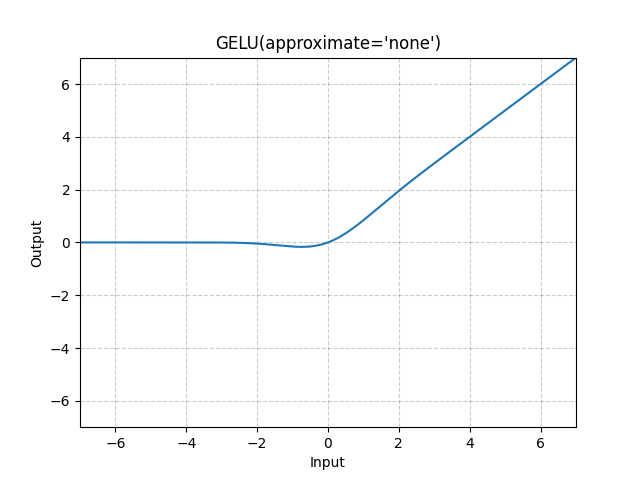

In [44]:
from IPython.display import Image
Image(filename='Images/GELU.png', width=400)

In [45]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout()

    def forward(self, hidden_states):
        x = self.fc1(hidden_states)
        x = self.gelu(x)
        
        x = self.fc2(x)
        x = self.dropout(x)

        return x

ffn = FeedForward(config)
ffn(attn_output)

tensor([[[ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000, -0.0394],
         [ 0.0106,  0.0351, -0.0208,  ..., -0.0482, -0.0187, -0.0000],
         [ 0.0012,  0.0612,  0.0000,  ..., -0.0695,  0.0000, -0.0000],
         [-0.0000,  0.0000,  0.0064,  ..., -0.0000,  0.0018, -0.0000]]],
       grad_fn=<MulBackward0>)

In [38]:
config, model.encoder.layer[0].intermediate, model.encoder.layer[0].output

(BertConfig {
   "architectures": [
     "BertForMaskedLM"
   ],
   "attention_probs_dropout_prob": 0.1,
   "classifier_dropout": null,
   "gradient_checkpointing": false,
   "hidden_act": "gelu",
   "hidden_dropout_prob": 0.1,
   "hidden_size": 768,
   "initializer_range": 0.02,
   "intermediate_size": 3072,
   "layer_norm_eps": 1e-12,
   "max_position_embeddings": 512,
   "model_type": "bert",
   "num_attention_heads": 12,
   "num_hidden_layers": 12,
   "pad_token_id": 0,
   "position_embedding_type": "absolute",
   "transformers_version": "4.55.4",
   "type_vocab_size": 2,
   "use_cache": true,
   "vocab_size": 30522
 },
 BertIntermediate(
   (dense): Linear(in_features=768, out_features=3072, bias=True)
   (intermediate_act_fn): GELUActivation()
 ),
 BertOutput(
   (dense): Linear(in_features=3072, out_features=768, bias=True)
   (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   (dropout): Dropout(p=0.1, inplace=False)
 ))

# 4. layer norm and skip connection
#### LayerNorm keeps activations balanced, making Transformer training stable and efficient.
- What: LayerNorm normalizes the hidden states across features for each token, keeping mean ≈ 0 and variance ≈ 1.
- Why: It stabilizes training, prevents exploding/vanishing activations, and helps gradients flow smoothly.


LayerNorm -> appears in two places
- embeddings
- output

Transformer -> **Post layer normalization** -> appears after the layer

# 5. EncoderLayer

In [50]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = MultiHeadAttention(config)
        self.ln1 = nn.LayerNorm(config.hidden_size)
        self.ffn = FeedForward(config)
        self.ln2 = nn.LayerNorm(config.hidden_size)

    def forward(self, x):
        x = x + self.ln1(self.attn(x))
        x = x + self.ln2(self.ffn(x))

        return x

In [53]:
encoder_layer = TransformerEncoderLayer(config)
encoder_layer(input_embeddings)

tensor([[[-0.9094,  1.4654, -2.3417,  ..., -1.1118,  0.1068,  0.2173],
         [ 2.1450,  0.4420, -0.2350,  ...,  2.4566,  0.3403,  0.1372],
         [-0.3365, -0.1628,  1.6537,  ...,  0.9059, -0.2222, -0.4539],
         [ 0.5115, -1.7077, -1.8344,  ...,  1.7755, -1.6591,  1.3973]]],
       grad_fn=<AddBackward0>)